## Can GPT4 Solve the ARC Challenge?
This notebook was created by John Tan Chong Min on 17 Apr 2023.
- Seek to use GPT4 via zero-shot prompt engineering to generate an output
- Fine-tuning the prompt to let GPT4 ground its answer has proven effective
- Works quite well for grids with small sizes
- Can be better if we ask GPT4 to generate the python code for its description, and use it to check validity based on input/output pairs.
- Can be even better if we have GPT4s with different biases and grounding, and increase diversity of possible generated code

In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import os
import copy

def load_json_data(folder):
    json_files = [pos_json for pos_json in os.listdir(folder) if pos_json.endswith('.json')]
    data = {}
    for js in json_files:
        with open(os.path.join(folder, js)) as json_file:
            data[js] = json.load(json_file)
    return data

def plot_2d_grid(data):
    cvals  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    colors = ["black", "dodgerblue", "red", "lightgreen", "yellow", "grey", "magenta", "orange", "lightblue", "brown"]
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

    fig, axs = plt.subplots(1, 3, figsize=(5, len(data['test']) * 3))
    print(axs.shape)
    axs[0].set_title('Test Input')
    axs[0].set_xticks([]); axs[0].set_yticks([])
    axs[0].imshow(np.array(data['test'][0]['input']), cmap=cmap, vmin=0, vmax=9)
    axs[1].set_title('Test Output')
    axs[1].set_xticks([]); axs[1].set_yticks([])
    axs[1].imshow(np.array(data['test'][0]['output']), cmap=cmap, vmin=0, vmax=9)
    # plot gpt output if present
    if data['gpt_output'] is not None:
        axs[2].set_title('GPT Output')
        axs[2].set_xticks([]); axs[2].set_yticks([])
        axs[2].imshow(np.array(data['gpt_output']), cmap=cmap, vmin=0, vmax=9) 
    else:
        axs[2].axis('off')

    fig, axs = plt.subplots(len(data['train']), 2, figsize=(5, len(data['train']) * 3))
    for i, example in enumerate(data['train']):
        axs[i, 0].set_title(f'Training Input {i}')
        axs[i, 0].set_xticks([]); axs[i, 0].set_yticks([])
        axs[i, 0].imshow(np.array(example['input']), cmap=cmap, vmin=0, vmax=9)
        axs[i, 1].set_title(f'Training Output {i}')
        axs[i, 1].set_xticks([]); axs[i, 1].set_yticks([])
        axs[i, 1].imshow(np.array(example['output']), cmap=cmap, vmin=0, vmax=9)
    plt.tight_layout()
    plt.show()

## Load the JSON files

- Download from https://lab42.global/wp-content/uploads/2022/08/ARC-800-tasks.zip

In [2]:
# !wget https://lab42.global/wp-content/uploads/2022/08/ARC-800-tasks.zip 
# !unzip ARC-800-tasks.zip -d ./ARC-800-tasks

--2023-04-18 07:38:28--  https://lab42.global/wp-content/uploads/2022/08/ARC-800-tasks.zip
Resolving lab42.global (lab42.global)... 217.26.61.45
Connecting to lab42.global (lab42.global)|217.26.61.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418121 (408K) [application/zip]
Saving to: 'ARC-800-tasks.zip.4'

ARC-800-tasks.zip.4 100%[===================>] 408.32K   482KB/s    in 0.8s    

2023-04-18 07:38:29 (482 KB/s) - 'ARC-800-tasks.zip.4' saved [418121/418121]

Archive:  ARC-800-tasks.zip
replace ./ARC-800-tasks/evaluation/00576224.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
# load the json files

# download the data from 
folder = 'ARC-800-tasks/evaluation'
myjson = load_json_data(folder)

## Get the JSON for the GPT input

In [3]:
task_name = '66e6c45b'
json_task = copy.deepcopy(myjson[task_name +'.json'])

preamble = '''You are given a series of inputs and output pairs. 
These are all in the form of a 2D array, representing a 2D grid, with values from 0-9. 
The values are not representative of any ordinal ranking. 
Input/output pairs may not reflect all possibilities, you are to infer the simplest possible relation making use of symmetry and invariance as much as possible.

The input can be something like:
> entire grid being the sandbox to manipulate
> using a part of the grid (individual squares or portions of the grid) to depict instructions of how to do the task. Position and symmetry is very important.
> using regions of similar value to depict area for answer of the task

The output can be something like:
> same output size as input after performing action
> output one of the fixed predetermined patterns used to classify the input image
> using output to show the ordering of objects, such as by size, height, width, position, value

Each of the input-output relation can be done with one or more actions chained together, which could be something like (not exhaustive):
- object view (defined as continuous squares connected horizontally, vertically and/or diagonally, separated by 0 values)
> objects can be the of the same value, or different values combined together
> objects may be hidden beneath other objects
> rotating or shifting objects
> changing value of object
> objects can be manipulated and mapped to a different number of output squares
> different objects may be manipulated differently based on context

- pixel view
> rotation / reflection symmetry
> continuation of a pattern
> changing values

- segment view
> combine two segments of the input into one single one based on a simple rule
> rule can be certain values are prioritized over others, or combination of values into new ones

Do the following:
- What is the broad description of the input/output relation that holds for all input/output pairs?
- What is the step by step description of the input/output relation that holds for all input/output pairs? 
- Apply this description to the test input and find out the answer 'to_be_filled'.'''

# ensure only one test output
json_task['test'] = json_task['test'][0]
json_task['test']['output'] = 'to_be_filled'

print(preamble + '\n\n' + str(json_task))

You are given a series of inputs and output pairs. 
These are all in the form of a 2D array, representing a 2D grid, with values from 0-9. 
The values are not representative of any ordinal ranking. 
Input/output pairs may not reflect all possibilities, you are to infer the simplest possible relation making use of symmetry and invariance as much as possible.

The input can be something like:
> entire grid being the sandbox to manipulate
> using a part of the grid (individual squares or portions of the grid) to depict instructions of how to do the task. Position and symmetry is very important.
> using regions of similar value to depict area for answer of the task

The output can be something like:
> same output size as input after performing action
> output one of the fixed predetermined patterns used to classify the input image
> using output to show the ordering of objects, such as by size, height, width, position, value

Each of the input-output relation can be done with one or more a

# Dispaly the GPT output

(3,)


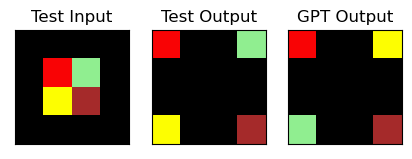

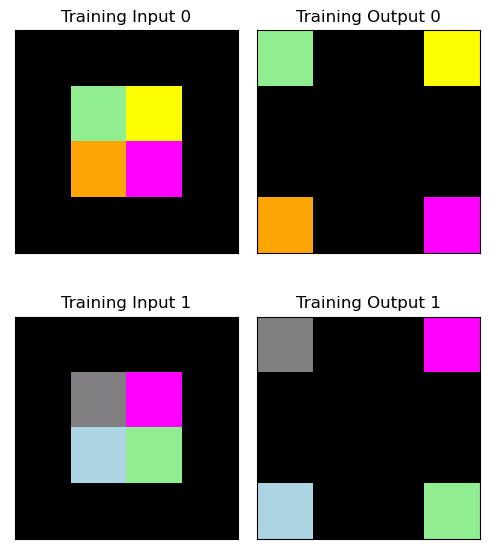

In [6]:
json_task = copy.deepcopy(myjson[task_name +'.json'])

# Add GPT output here (if any)
json_task['gpt_output'] = [
[2, 0, 0, 4],
[0, 0, 0, 0],
[0, 0, 0, 0],
[3, 0, 0, 9]
]

# json_task['gpt_output'] = None

plot_2d_grid(json_task)